In [1]:
%matplotlib inline
import numpy as np
import power_laws
import rubisco_data
import matplotlib.colors
import seaborn as sns
import pandas as pd

from scipy.stats import linregress, gmean, pearsonr
from scipy.stats import gmean
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
cols = ['S', 'vC', 'KC', 'kon_C', 'KRuBP', 'vO', 'KO', 'kon_O']
titles = {'S': '$S_{C/O}$',
          'vC': '$k_{cat,C}$',
          'KC': '$K_C$',
          'vO': '$k_{cat,O}$',
          'KO': '$K_O$',
          'kon_C': '$k_{cat,C}/K_C$',
          'kon_O': '$k_{cat,O}/K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless',
         'vC': '$s^{-1}$',
         'KC': '$\mu M$',
         'vO': '$s^{-1}$',
         'KO': '$\mu M$',
         'kon_C': '$\mu M^{-1} s^{-1}$',
         'kon_O': '$\mu M^{-1} s^{-1}$',
         'KRuBP': '$\mu M$'}
xlim = {'S': (1, 1e3),
        'vC': (1e-2, 20),
        'vO':(1e-2, 20),
        'KC': (1, 7e3),
        'KO': (1, 7e3),
        'kon_C': (1e-4, 1e0),
        'kon_O': (1e-4, 1e0),
        'KRuBP': (0.1, 1.5e2)}
groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}
median_colors = {'1': 'marine blue', 
                 '2': 'mustard yellow',}

kin_vars = 'KC, vC, S, KO, KRuBP, vO'.split(', ')
kin_var_SDs = ['%s_SD' % s for s in kin_vars]
kin_cols = kin_vars + kin_var_SDs

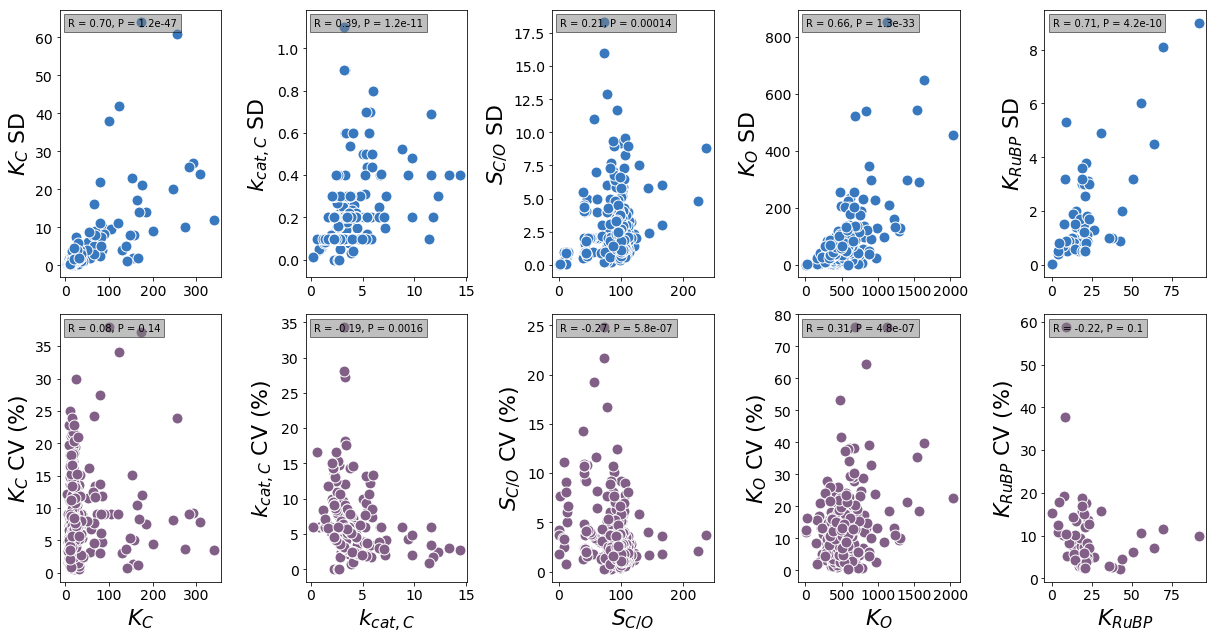

In [4]:
# Plotting the reported SD and CV for all directly measured parameters
figure = plt.figure(figsize=(17,9))

# Top row is SD
color = named_colors[0]
for i, (v, v_sd) in enumerate(zip(kin_vars, kin_var_SDs)): 
    if v == 'vO':
        # skip vO since it is not directly measured. 
        continue
        
    ax = plt.subplot(2,5, i+1)
    
    mask = np.logical_and(raw_kin_df[v].notnull(), raw_kin_df[v_sd].notnull())
    masked_df = raw_kin_df[mask]
    rval, pval = pearsonr(masked_df[v], masked_df[v_sd])
    
    plt.scatter(masked_df[v], masked_df[v_sd], color=color, edgecolors='w', s=120)
    t = plt.text(0.05, 0.95, 'R = %.2f, P = %.2g' % (rval, pval),
         horizontalalignment='left',
         verticalalignment='center',
         transform=ax.transAxes)
    t.set_bbox(dict(facecolor='grey', alpha=0.5))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('')
    plt.ylabel(titles[v] + ' SD', fontsize=22)
    
# Second row is CV, different color
color = named_colors[3]
for i, (v, v_sd) in enumerate(zip(kin_vars, kin_var_SDs)): 
    if v == 'vO':
        continue
        
    ax = plt.subplot(2,5, i+1+5)
    
    mask = np.logical_and(raw_kin_df[v].notnull(), raw_kin_df[v_sd].notnull())
    masked_df = raw_kin_df[mask]
    cv = masked_df[v_sd] / masked_df[v]
    rval, pval = pearsonr(masked_df[v], cv)
    
    plt.scatter(masked_df[v], 100*cv, color=color, edgecolors='w', s=120)
    t = plt.text(0.05, 0.95, 'R = %.2f, P = %.2g' % (rval, pval),
         horizontalalignment='left',
         verticalalignment='center',
         transform=ax.transAxes)
    t.set_bbox(dict(facecolor='grey', alpha=0.5))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(titles[v], fontsize=22)
    plt.ylabel(titles[v] + ' CV (%)', fontsize=22)
    
plt.tight_layout()
plt.savefig('figS3/figS3_measured_params_SD_CV.png', dpi=600)
plt.show()

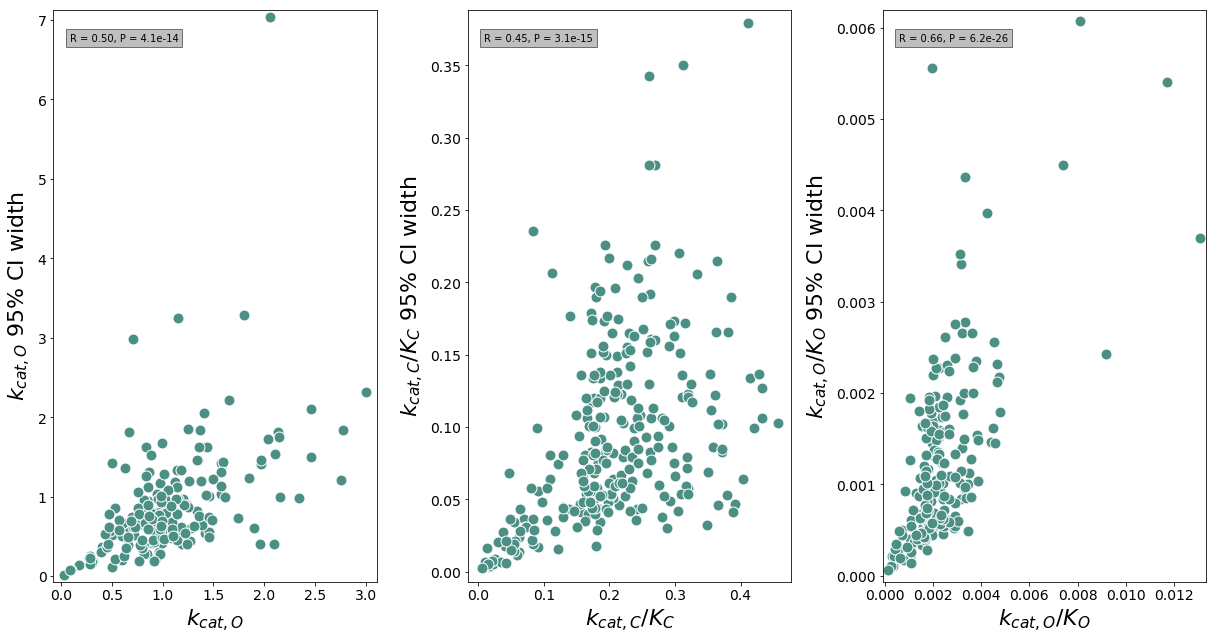

In [5]:
# Plotting inferred confidence interval width for inferred values
inferred_vars = 'vO, kon_C, kon_O'.split(', ')

figure = plt.figure(figsize=(17,9))

color = named_colors[4]
for i, v in enumerate(inferred_vars): 
        
    ax = plt.subplot(1,3, i+1)
    
    high_name = v + '_95CI_high'
    low_name = v + '_95CI_low'

    # should have 95 CI wherever we have values
    masked_df = raw_kin_df[raw_kin_df[v].notnull()]
    vals = masked_df[v]
    ci_width = masked_df[high_name] - masked_df[low_name]
    rval, pval = pearsonr(vals, ci_width)
    
    plt.scatter(vals, ci_width, color=color, edgecolors='w', s=120)
    t = plt.text(0.05, 0.95, 'R = %.2f, P = %.2g' % (rval, pval),
         horizontalalignment='left',
         verticalalignment='center',
         transform=ax.transAxes)
    t.set_bbox(dict(facecolor='grey', alpha=0.5))
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(titles[v], fontsize=22)
    plt.ylabel(titles[v] + ' 95% CI width', fontsize=22)
    
    xmin, xmax = np.nanmin(vals), np.nanmax(vals)
    ymin, ymax = np.nanmin(ci_width), np.nanmax(ci_width)
    xfudge = np.nanmean(vals) / 10
    yfudge = np.nanmean(ci_width) / 10
    plt.xlim(xmin - xfudge, xmax + xfudge)
    plt.ylim(ymin - yfudge, ymax + yfudge)
    
    
plt.tight_layout()
plt.savefig('figS3/figS3_inferred_params_CIs.png', dpi=600)
plt.show()